#Environment setup

In [ ]:
!pip install librosa
!pip install soundfile
!pip install resampy
!git clone https://github.com/linkAmy/IMEMNet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.2 MB/s eta 0:00:00
Cloning into 'IMEMNet'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 6), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (26/26), 2.60 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
import pandas as pd
import librosa
import numpy as np
import warnings
from PIL import Image
import os
import matplotlib.pyplot as plt

import resampy
import torch
import torchaudio
import soundfile as sf
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet50,  ResNet18_Weights, ResNet50_Weights

##Useful functions and variables

In [ ]:
IMEMNET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet"
train_annotation_file = IMEMNET_PATH + "/train_matching_filtered.csv"
val_annotation_file = IMEMNET_PATH + "/val_matching_filtered.csv"
test_annotation_file = IMEMNET_PATH + "/test_matching_filtered.csv"

In [ ]:
def read_img_va_csv(csv_path, delimiter, index_col=None):
  data_csv = pd.read_csv(csv_path, delimiter=delimiter, index_col=index_col)

  v_no_val = data_csv[data_csv["valence_mean"] == -1]
  a_no_val = data_csv[data_csv["arousal_mean"] == -1]

  concatRes = pd.concat([v_no_val,a_no_val])
  concatRes = concatRes[~concatRes.index.duplicated(keep='first')]

  data_csv = data_csv[~data_csv.index.isin(concatRes.index)]

  return data_csv

#IMEMNet Dataset

In [ ]:
img_preprocess = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((224,224))
])

In [ ]:
tr_pair_labels = pd.read_csv(train_annotation_file,
                          delimiter=",",
                          dtype={"index": int,"WAV_FILE":str, "IMG_FILE":str, "Score":float})

val_pair_labels = pd.read_csv(val_annotation_file,
                          delimiter=",",
                          dtype={"index": int,"WAV_FILE":str, "IMG_FILE":str, "Score":float})

test_pair_labels = pd.read_csv(test_annotation_file,
                          delimiter=",",
                          dtype={"index": int,"WAV_FILE":str, "IMG_FILE":str, "Score":float})



wav_va_labels = pd.read_csv(IMEMNET_PATH + "/deam_annotations/va_annotation_normalise.csv",
                            index_col="song_id")

img_va_labels = read_img_va_csv(IMEMNET_PATH + "/va_image_normalise.csv", delimiter=",")

In [ ]:
class IMEMNetDataset(Dataset):

  def __init__(self, pair_labels, wav_va_labels, img_va_labels, imemnet_dir, img_transform):

        #Music-Image pair dataset
        self.pair_labels = pair_labels
        #Music directory
        self.wav_dir = imemnet_dir + "/cut_audio"
        #Image directory
        self.img_dir = imemnet_dir
        #Music Valence-Arousal dataset
        self.wav_va_labels = wav_va_labels
        #Image Valence-Arousal dataset
        self.img_va_labels = img_va_labels
        self.img_transform = img_transform

  def __len__(self):
        return len(self.pair_labels)

  def __getitem__(self, idx):

        #2nd index: 0->WAV_FILE 1->IMG_FILE 2->Score
        wav_file = self.pair_labels.iloc[idx, 0]
        img_file = self.pair_labels.iloc[idx, 1]
        similarity = self.pair_labels.iloc[idx, 2]

        #Extract music features and VA ground truth
        wav, wav_va_label = self.load_wav(wav_file)

        #Retrieve image and VA ground truth
        img, img_va_label = self.load_img(img_file)

        return (wav,img), (wav_va_label, img_va_label), np.float32(similarity)

  def load_wav(self, wav_file):
        wav_path = '/'.join((self.wav_dir, wav_file + ".wav"))
        wav_feat = self.extract_wav_feat(wav_path)
        wav = torch.stack((wav_feat, wav_feat, wav_feat), 0)
        wav_num = int(wav_file.split("-")[0])

        wav_record = self.wav_va_labels.loc[wav_num]
        wav_va_label = torch.tensor([wav_record.valence_mean,wav_record.arousal_mean])

        return wav.type(torch.float32), wav_va_label.type(torch.float32)

  def load_img(self, img_file):

        img_file = img_file + ".jpg"
        img_record = self.img_va_labels[self.img_va_labels.filename == img_file]
        assert isinstance(img_record, pd.DataFrame)
        if len(img_record) > 1:
            img_record = img_record.sample(1)
            assert isinstance(img_record, pd.DataFrame)

        img_serie = img_record.squeeze(axis=0) #convert DataFrame to Series
        img_subdir = img_serie.from_folder + "/images"
        # print(self.img_dir, img_subdir, img_file)
        img_path = '/'.join((self.img_dir, img_subdir ,img_file))
        img = self.img_transform(Image.open(img_path).convert('RGB'))
        img_va_label = torch.tensor([img_serie.valence_mean,img_serie.arousal_mean])

        return img.type(torch.float32), img_va_label.type(torch.float32)

  def extract_wav_feat(self, wav_path):

        sr = 22050
        y, old_sr = sf.read(wav_path)
        y = resampy.resample(y, old_sr, sr)

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        # print(mfccs.shape)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        # print(chroma.shape)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        # print(contrast.shape)
        tonal_centroid = librosa.feature.tonnetz(y=y, sr=sr)
        # print(tonal_centroid.shape)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr)
        # print(melspec.shape)

        wav_feat = np.concatenate([mfccs,chroma,contrast,tonal_centroid,melspec])
        # print(wav_feat.shape)
        return torch.tensor(wav_feat)


##Dataset

In [ ]:
train_dataset = IMEMNetDataset(tr_pair_labels,wav_va_labels,img_va_labels,IMEMNET_PATH, img_preprocess)
print(f'Train size {len(train_dataset)}')
val_dataset = IMEMNetDataset(val_pair_labels,wav_va_labels,img_va_labels,IMEMNET_PATH, img_preprocess)
print(f'Val size {len(val_dataset)}')
test_dataset = IMEMNetDataset(test_pair_labels,wav_va_labels,img_va_labels,IMEMNET_PATH, img_preprocess)
print(f'Test size {len(test_dataset)}')

Train size 101900
Val size 8307
Test size 24688


Test the dataset works

In [ ]:
index = 6
files = train_dataset.pair_labels.iloc[index]
print(train_dataset.pair_labels.head())
print(f'Sound {files[0]}.wav')
print(f'Image {files[1]}.jpg')

x,y,sim_score = train_dataset.__getitem__(index)
print(f'.wav music feature shape: {x[0].shape, x[0].dtype}, gt={y[0]}')
print(f'.jpg image shape : {x[1].shape, x[1].dtype}, gt={y[1]}')
print(f'Similarity score: {sim_score}')

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

  WAV_FILE                     IMG_FILE     Score
0   480-17  COCO_train2014_000000541918  0.095942
1  1426-15  COCO_train2014_000000117772  0.874375
2   163-16  COCO_train2014_000000520769  0.136823
3   1011-9       frame_f2o5jjlo08ep8e27  0.467178
4  1840-16  COCO_train2014_000000381116  0.728462
Sound 1599-18.wav
Image COCO_val2014_000000039106.jpg


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


.wav music feature shape: (torch.Size([3, 193, 87]), torch.float32), gt=tensor([0.2941, 0.3846])
.jpg image shape : (torch.Size([3, 224, 224]), torch.float32), gt=tensor([0.4444, 0.6111])
Similarity score: 0.9591113328933716


##DataLoader

In [ ]:
batch_size = 128

train_size = len(train_dataset)
indices = torch.randperm(train_size)[:int(0.1*train_size)]
train_subdataset = torch.utils.data.Subset(train_dataset, indices.tolist())
print(f'train subset dataset size {len(train_subdataset)}')

val_size = len(val_dataset)
indices = torch.randperm(val_size)[:int(0.1*val_size)]
val_subdataset = torch.utils.data.Subset(val_dataset, indices.tolist())
print(f'train subset dataset size {len(val_subdataset)}')

test_size = len(test_dataset)
indices = torch.randperm(test_size)[:int(0.1*test_size)]
test_subdataset = torch.utils.data.Subset(test_dataset, indices.tolist())
print(f'test subset dataset size {len(test_subdataset)}')

train subset dataset size 10190
train subset dataset size 830
test subset dataset size 2468


In [ ]:
train_dataloader = DataLoader(train_subdataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_subdataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_subdataset, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

80
7
20


#CDCML


##Load model

In [ ]:
class CDCML(nn.Module):

  def __init__(self, feat_dim: int = 512):
    super().__init__()
    self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
    self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

    #Remove last FC layer
    # self.resnet50.fc = nn.Identity()
    self.resnet18.fc = nn.Identity()
    self.resnet50.fc = nn.Identity()

    #Add our own FC layer
    self.img_feat_extractor = nn.Sequential(
        self.resnet50,
        nn.Linear(2048, feat_dim)
    )

    self.music_feat_extractor = nn.Sequential(
        self.resnet18,
        nn.Linear(512, feat_dim)
    )

    self.va_predictor = nn.Sequential(
        nn.Linear(feat_dim, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, 2),
        nn.BatchNorm1d(2),
        nn.Sigmoid()
    )

    self.sim_predictor = nn.Sequential(
        nn.Linear(feat_dim * 2, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, 1),
        nn.BatchNorm1d(1),
        nn.Sigmoid()
    )

  def forward(self, x):

    wav_feat, img = x
    wav_emb = self.music_feat_extractor(wav_feat) #(batch_size, 512)
    img_emb = self.img_feat_extractor(img)      #(batch_size, 512)

    emb_concat = torch.cat([wav_emb, img_emb],dim=1)
    sim_pred = self.sim_predictor(emb_concat)
    wav_va_pred = self.va_predictor(wav_emb)
    img_va_pred = self.va_predictor(img_emb)

    return wav_emb, img_emb, sim_pred, wav_va_pred, img_va_pred


In [ ]:
fname = "epoch=001_tr_loss=5052.469727.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_model_ckpt(fname=None):

  cdcml = CDCML()
  optimizer = torch.optim.SGD(cdcml.parameters(), lr= 1e-3)
  scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
  if fname!= None:
    print("Loading from checkpoint " + fname)
    ckpt = torch.load(f'{IMEMNET_PATH}/output/{fname}', map_location=torch.device(device))

    cdcml.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
  return cdcml, optimizer, scheduler

def get_prev_losses(fname=None):
  if fname != None:
    ckpt = torch.load(f'{IMEMNET_PATH}/output/{fname}', map_location=torch.device(device))
    return ckpt['losses'],ckpt['losses_cfr'], ckpt['losses_cfm'], ckpt['losses_sfr_i'], ckpt["losses_sfr_m"], ckpt['losses_sim'], ckpt['losses_iva'], ckpt['losses_mva']
  else :
    return [],[],[],[],[],[],[],[]

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

cdcml, optimizer, scheduler = get_model_ckpt(fname)
cdcml = cdcml.to(device)
losses,losses_cfr, losses_cfm, losses_sfr_i,losses_sfr_m, losses_sim, losses_iva, losses_mva = get_prev_losses(fname)
num_epochs = 5

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


Loading from checkpoint epoch=001_tr_loss=5052.469727.pth


In [ ]:
import os
def save_checkpoint(model, optimizer, scheduler, epoch,
                    losses,
                    losses_cfr,
                    losses_cfm,
                    losses_sfr_i,
                    losses_sfr_m,
                    losses_sim,
                    losses_iva,
                    losses_mva):
    archive = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "epoch": epoch,
        "losses": losses,
        "losses_cfr" : losses_cfr,
        "losses_cfm" : losses_cfm,
        "losses_sfr_i" : losses_sfr_i,
        "losses_sfr_m" : losses_sfr_m,
        "losses_sim" : losses_sim,
        "losses_iva" : losses_iva,
        "losses_mva" : losses_mva
    }
    ckpt_path = os.path.join(f'{IMEMNET_PATH}/output',
                             "epoch={:03d}_tr_loss={:.6f}.pth".format(
                                 epoch, sum(losses)/len(losses)
                             ))
    torch.save(archive, ckpt_path)
    print("Checkpoint written to -> {}".format(ckpt_path))


##Validation

In [ ]:
mse = torch.nn.functional.mse_loss
mae = torch.nn.L1Loss()

def validate():
    cdcml.eval()

    sim_mse = 0
    sim_mae = 0
    wav_v_mse = 0
    wav_a_mse = 0
    wav_v_mae = 0
    wav_a_mae = 0
    img_v_mse = 0
    img_a_mse = 0
    img_v_mae = 0
    img_a_mae = 0
    for x,y,sim_score in val_dataloader:
        with torch.no_grad():

            wav_feat = x[0].to(device)
            wav_va = y[0].to(device)
            img = x[1].to(device)
            img_va = y[1].to(device)
            sim_score = sim_score.to(device)

            wav_emb, img_emb, sim_pred, wav_va_pred, img_va_pred = cdcml((wav_feat,img))

            wav_v_pred = wav_va_pred[0]
            wav_a_pred = wav_va_pred[1]
            img_v_pred = img_va_pred[0]
            img_a_pred = img_va_pred[1]

            sim_mse += mse(sim_pred.squeeze(1), sim_score)
            sim_mae += mae(sim_pred.squeeze(1), sim_score)

            wav_v_mse += mse(wav_v_pred, wav_va[0])
            wav_a_mse += mse(wav_a_pred, wav_va[1])

            wav_v_mae += mae(wav_v_pred, wav_va[0])
            wav_a_mae += mae(wav_a_pred, wav_va[1])

            img_v_mse += mse(img_v_pred, img_va[0])
            img_a_mse += mse(img_a_pred, img_va[1])

            img_v_mae += mae(img_v_pred, img_va[0])
            img_a_mae += mae(img_a_pred, img_va[1])

    sim_mse /= len(test_dataloader)
    sim_mae /= len(test_dataloader)
    wav_v_mse /= len(test_dataloader)
    wav_a_mse /= len(test_dataloader)
    wav_v_mae /= len(test_dataloader)
    wav_a_mae /= len(test_dataloader)
    img_v_mse /= len(test_dataloader)
    img_a_mse /= len(test_dataloader)
    img_v_mae /= len(test_dataloader)
    img_a_mae /= len(test_dataloader)
    print('---------------------------------------')
    print(f'Epoch {epoch} validation')
    print(f'Similarity MSE {sim_mse}')
    print(f'Similarity MAE {sim_mae}')
    print(f'Music V MSE {wav_v_mse}')
    print(f'Music V MAE {wav_v_mae}')
    print(f'Music A MSE {wav_a_mse}')
    print(f'Music A MAE {wav_a_mae}')
    print(f'Image V MSE {img_v_mse}')
    print(f'Image V MAE {img_v_mae}')
    print(f'Image A MSE {img_a_mse}')
    print(f'Image A MAE {img_a_mae}')
    print('---------------------------------------')

##Train

In [ ]:
# losses = []
# losses_cfr = []
# losses_cfm = []
# losses_sfr_i = []
# losses_sfr_m = []
# losses_sim = []
# losses_iva = []
# losses_mva = []
# mse = torch.nn.functional.mse_loss
# mae = torch.nn.L1Loss()
iter = 0

torch.set_grad_enabled(True)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)

    for epoch in range(2,3):

      cdcml.train()

      for x,y,sim_score in train_dataloader:

        optimizer.zero_grad()

        wav_feat = x[0].to(device)
        wav_va = y[0].to(device)
        img = x[1].to(device)
        img_va = y[1].to(device)
        sim_score = sim_score.to(device)

        wav_emb, img_emb, sim_pred, wav_va_pred, img_va_pred = cdcml((wav_feat,img))
        #----------------------------Embedding space losses----------------------------
        loss_cfr = l_cfr(wav_emb, wav_va, img_emb, img_va)
        # print(loss_cfr)

        loss_cfm = l_cfm(wav_emb, img_emb)
        # print(loss_cfm)

        loss_sfr_i = l_sfr_i(img_emb, img_va)
        # print(loss_sfr_i)
        loss_sfr_m = l_sfr_m(wav_emb, wav_va)
        # print(loss_sfr_m)
        #-------------------------------------------------------------------------------


        #----------------------------Label space losses----------------------------
        loss_sim = l_sim(sim_pred, sim_score )
        # print(loss_sim)
        loss_iva = l_iva(img_va_pred, img_va)
        # print(loss_iva)
        loss_mva = l_mva(wav_va_pred, wav_va)
        # print(loss_mva)

        loss = loss_cfr + loss_cfm + loss_sfr_i + loss_sfr_m + loss_sim + loss_iva + loss_mva
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu())
        losses_cfr.append(loss_cfr.detach().cpu())
        losses_cfm.append(loss_cfm.detach().cpu())
        losses_sfr_i.append(loss_sfr_i.detach().cpu())
        losses_sfr_m.append(loss_sfr_m.detach().cpu())
        losses_sim.append(loss_sim.detach().cpu())
        losses_iva.append(loss_iva.detach().cpu())
        losses_mva.append(loss_mva.detach().cpu())

        iter += 1

        if iter % (len(train_dataloader) // 10) == 0 and iter != 0:
          print(f'Iteration {iter} loss: {loss}')
        if iter % (len(train_dataloader) // 2) == 0 and iter != 0:
          save_checkpoint(cdcml,optimizer,scheduler,epoch,losses,losses_cfr, losses_cfm, losses_sfr_i,losses_sfr_m, losses_sim, losses_iva, losses_mva)


      scheduler.step()
      validate()


Iteration 8 loss: 4131.18115234375
Iteration 16 loss: 5477.18701171875
Iteration 24 loss: 3633.773193359375
Iteration 32 loss: 3320.05517578125
Iteration 40 loss: 7317.8310546875
Checkpoint written to -> /content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/output/epoch=002_tr_loss=5079.029297.pth


KeyboardInterrupt: 

##Evaluation

In [ ]:
cdcml.eval()
mse = torch.nn.functional.mse_loss
mae = torch.nn.L1Loss()

sim_mse = 0
sim_mae = 0
wav_v_mse = 0
wav_a_mse = 0
wav_v_mae = 0
wav_a_mae = 0
img_v_mse = 0
img_a_mse = 0
img_v_mae = 0
img_a_mae = 0

for x,y,sim_score in test_dataloader:

  with torch.no_grad():

      wav_feat = x[0].to(device)
      wav_va = y[0].to(device)
      img = x[1].to(device)
      img_va = y[1].to(device)
      sim_score = sim_score.to(device)

      wav_emb, img_emb, sim_pred, wav_va_pred, img_va_pred = cdcml((wav_feat,img))

      wav_v_pred = wav_va_pred[0]
      wav_a_pred = wav_va_pred[1]
      img_v_pred = img_va_pred[0]
      img_a_pred = img_va_pred[1]

      sim_mse += mse(sim_pred.squeeze(1), sim_score)
      sim_mae += mae(sim_pred.squeeze(1), sim_score)

      wav_v_mse += mse(wav_v_pred, wav_va[0])
      wav_a_mse += mse(wav_a_pred, wav_va[1])

      wav_v_mae += mae(wav_v_pred, wav_va[0])
      wav_a_mae += mae(wav_a_pred, wav_va[1])

      img_v_mse += mse(img_v_pred, img_va[0])
      img_a_mse += mse(img_a_pred, img_va[1])

      img_v_mae += mae(img_v_pred, img_va[0])
      img_a_mae += mae(img_a_pred, img_va[1])

sim_mse /= len(test_dataloader)
sim_mae /= len(test_dataloader)
wav_v_mse /= len(test_dataloader)
wav_a_mse /= len(test_dataloader)
wav_v_mae /= len(test_dataloader)
wav_a_mae /= len(test_dataloader)
img_v_mse /= len(test_dataloader)
img_a_mse /= len(test_dataloader)
img_v_mae /= len(test_dataloader)
img_a_mae /= len(test_dataloader)

print(f'Similarity MSE {sim_mse}')
print(f'Similarity MAE {sim_mae}')
print(f'Music V MSE {wav_v_mse}')
print(f'Music V MAE {wav_v_mae}')
print(f'Music A MSE {wav_a_mse}')
print(f'Music A MAE {wav_a_mae}')
print(f'Image V MSE {img_v_mse}')
print(f'Image V MAE {img_v_mae}')
print(f'Image A MSE {img_a_mse}')
print(f'Image A MAE {img_a_mae}')

##Loss curve

In [ ]:
# losses = list(map(lambda x: x.detach().cpu(),losses))
# losses_cfr = list(map(lambda x: x.detach().cpu(),losses_cfr))
# losses_cfm = list(map(lambda x: x.detach().cpu(),losses_cfm))
# losses_sfr_i = list(map(lambda x: x.detach().cpu(),losses_sfr_i))
# losses_sfr_m = list(map(lambda x: x.detach().cpu(),losses_sfr_m))
# losses_sim = list(map(lambda x: x.detach().cpu(),losses_sim))
# losses_iva = list(map(lambda x: x.detach().cpu(),losses_iva))
# losses_mva = list(map(lambda x: x.detach().cpu(),losses_mva))

# save_checkpoint(cdcml,optimizer,scheduler,epoch,losses,losses_cfr, losses_cfm, losses_sfr_i,losses_sfr_m, losses_sim, losses_iva, losses_mva)

Checkpoint written to -> /content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/output/epoch=002_tr_loss=5079.029297.pth


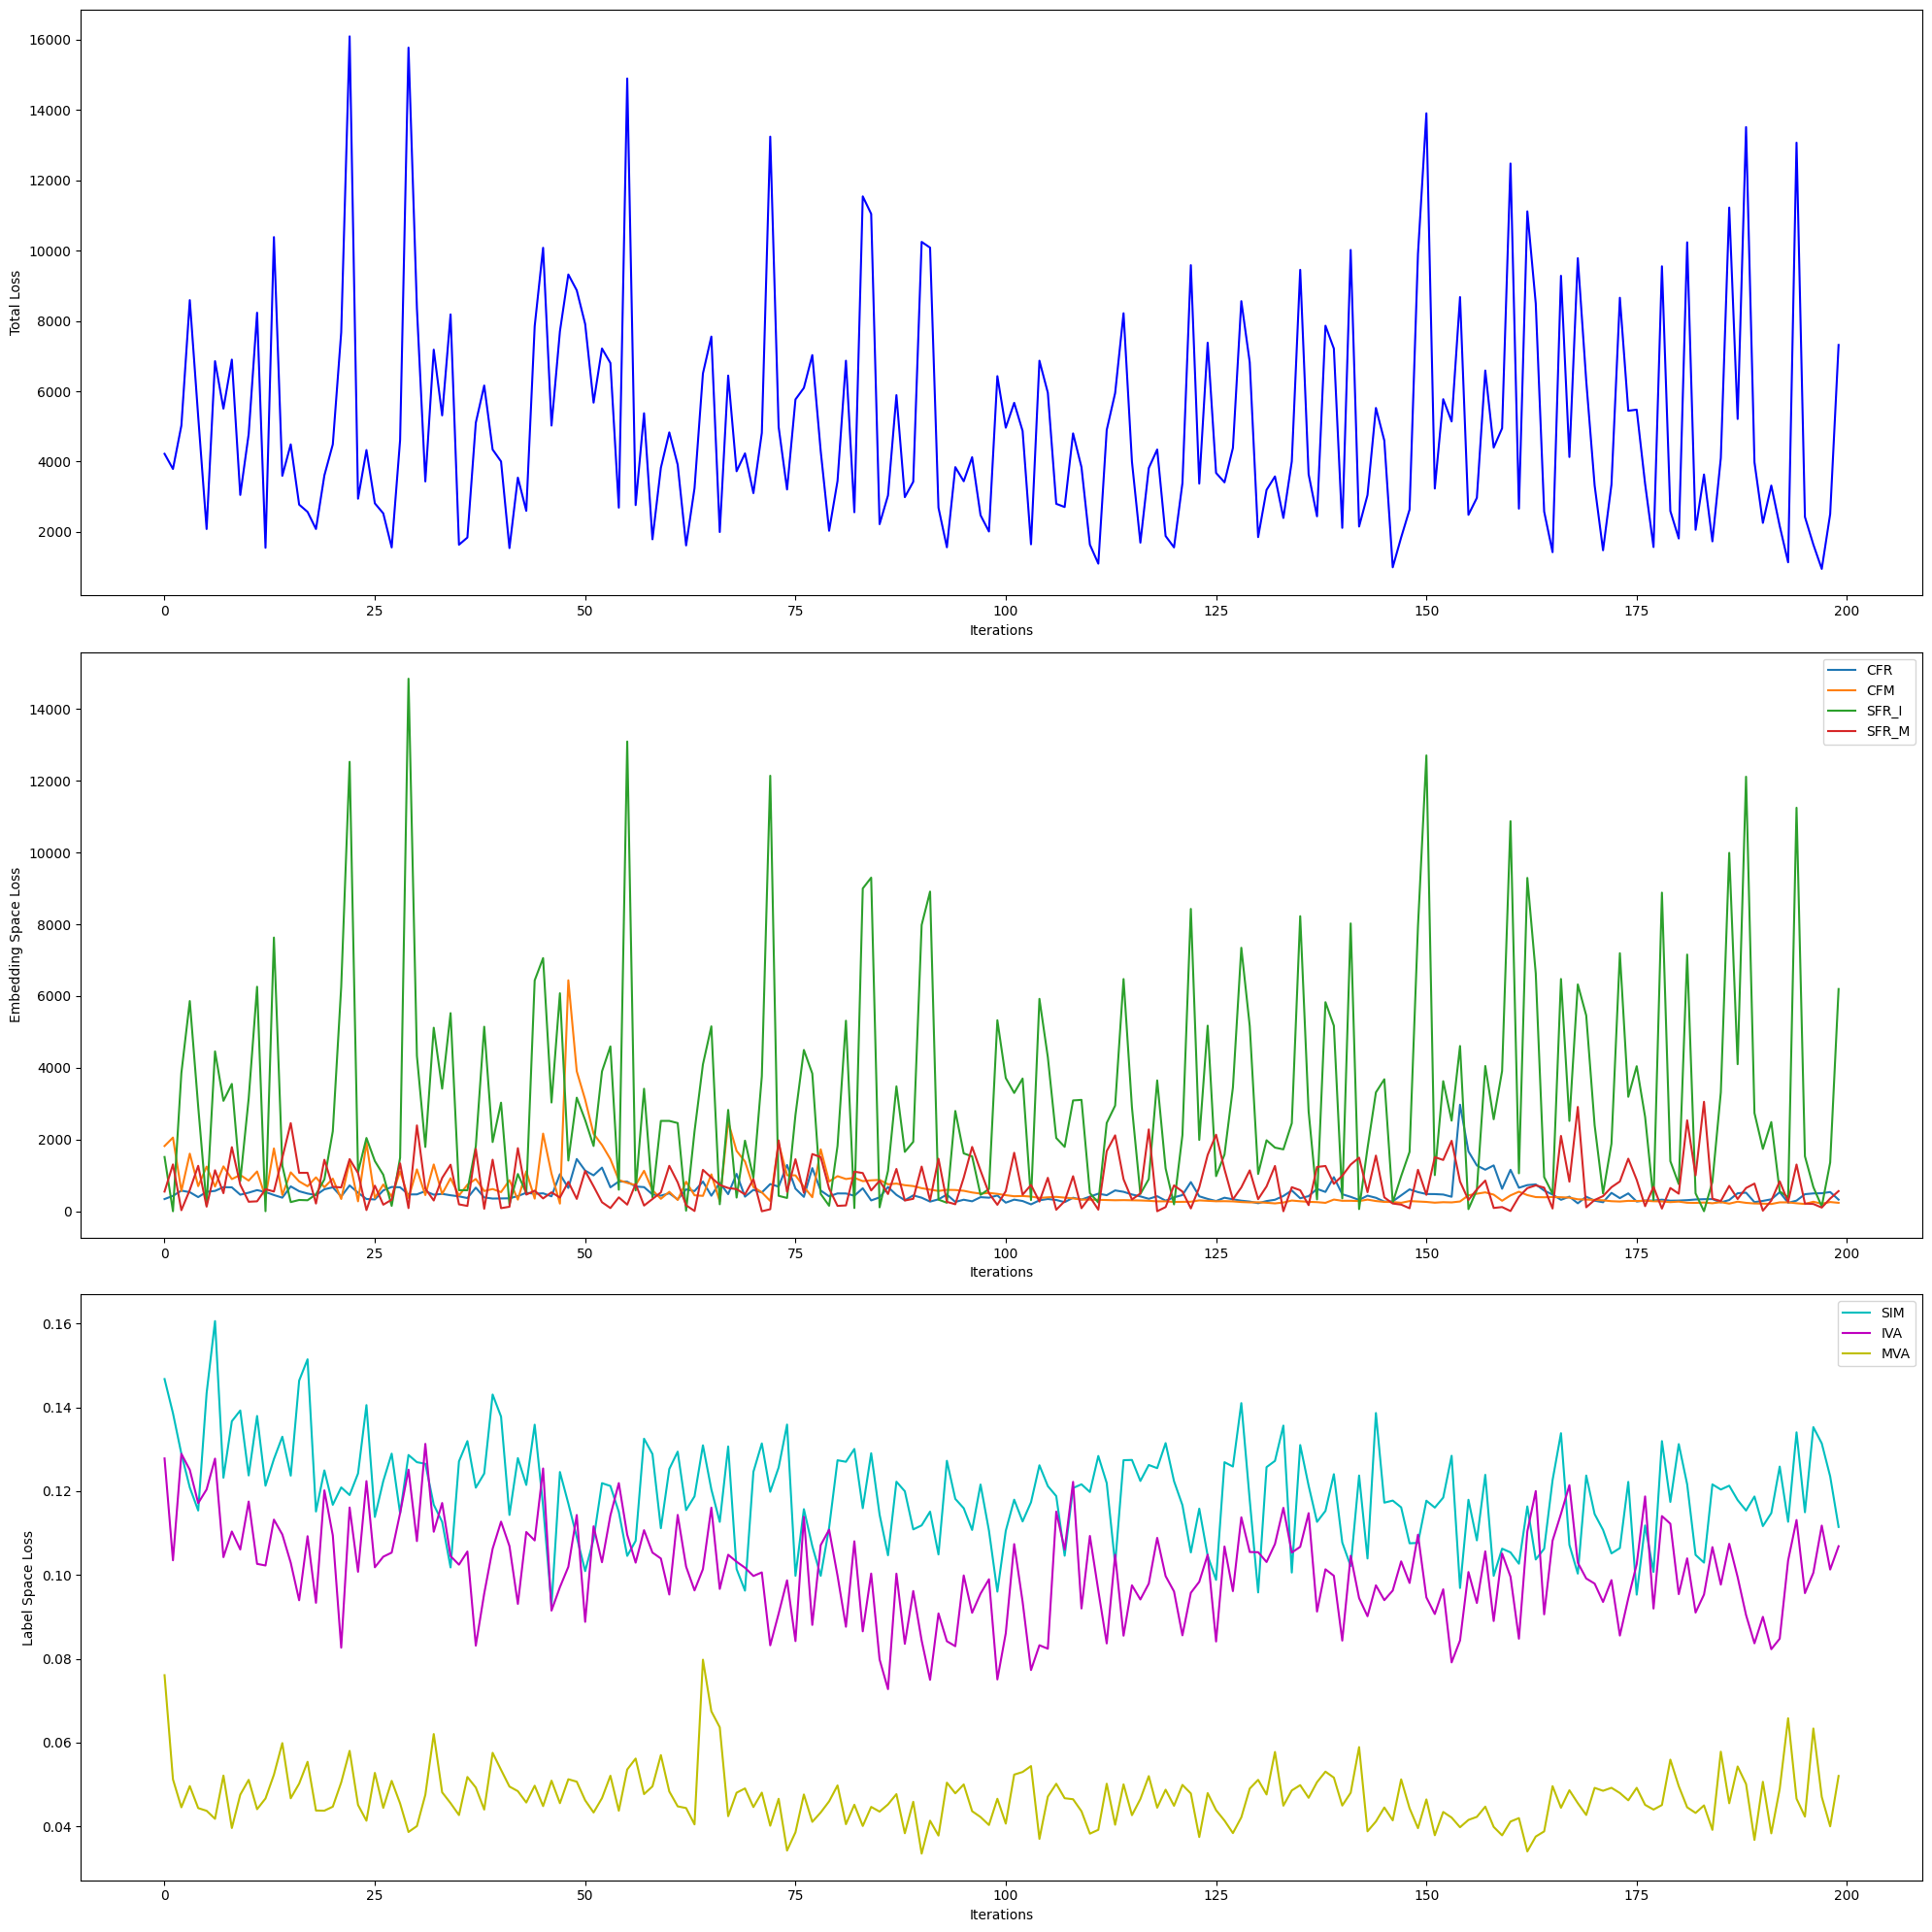

In [ ]:
fig,ax = plt.subplots(3, figsize= (20,20))

# losses_cfr = [random.random() for _ in range(iter)]
# losses_cfm =  [random.random() for _ in range(iter)]
iters = [i for i in range(len(losses))]

ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Total Loss")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Embedding Space Loss")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Label Space Loss")

ax[0].plot(iters, losses, "b")

ax[1].plot(iters, losses_cfr, label='CFR')
ax[1].plot(iters, losses_cfm, label="CFM")
ax[1].plot(iters, losses_sfr_i, label="SFR_I")
ax[1].plot(iters, losses_sfr_m, label="SFR_M")
ax[1].legend(loc='upper right')

ax[2].plot(iters, losses_sim, label="SIM", color= "c")
ax[2].plot(iters, losses_iva, label="IVA", color="m")
ax[2].plot(iters, losses_mva, label="MVA", color="y")
ax[2].legend(loc='upper right')

fig.tight_layout()

#Similarity score

In [ ]:
pdist = nn.PairwiseDistance(p=2)

def squared_euclid_dist(wav_feat, img_feat):

  return pdist(wav_feat, img_feat).pow(2)


In [ ]:
def subsample_va_population(batch_size):

  #Subsample VA population (Each music clip matching 50 images (random 30, largest 10, smallest 10))
  random_img = train_dataset.img_va_labels.sample(30*batch_size, replace=True)
  random_va = torch.tensor(random_img[["valence_mean", "arousal_mean"]].values)
  random_va = random_va.reshape((batch_size, 30, 2))

  ten_largest_img = train_dataset.pair_labels.nlargest(10, "Score")["IMG_FILE"].apply(lambda img: img + ".jpg").tolist()
  ten_smallest_img = train_dataset.pair_labels.nsmallest(10, "Score")["IMG_FILE"].apply(lambda img: img + ".jpg").tolist()

  largest_va = torch.rand((10,2)).repeat(batch_size,1,1)
  smallest_va = torch.rand((10,2)).repeat(batch_size,1,1)

  sample_va = torch.cat([random_va,largest_va,smallest_va], axis=1)
  #shuffle sample by generating number 0-50 without duplicates
  shuffle_indices = torch.randperm(sample_va.size(1))
  shuffled_sample_va = sample_va[:,shuffle_indices,:]
  #sample based on shuffled data
  shuffle_indices = torch.randperm(int(sample_va.size(1) * 0.1))
  subsample_va = sample_va[:,shuffle_indices,:]

  return subsample_va.type(torch.float32)

# Among them, 30 are randomly selected from the image dataset, and the remaining
# 20 are composed of 10 with highest matching score and 10 with thelowest.
# Finally, we randomly sample 10% of the pairs to constitute# the IMEMNet datase
def similarity_score(wav_va, img_va):
  pdist = nn.PairwiseDistance(p=2)
  batch_size = wav_va.size(0)
  #Numerator
  dist = pdist(wav_va, img_va)

  subsample_va = subsample_va_population(batch_size).to(device)

  #Denominator
  dists = torch.cdist(wav_va.unsqueeze(dim=1), subsample_va, p=2.0)
  avg_dist = torch.mean(dists, dim=2).squeeze(axis=1)

  sim_pred = dist/avg_dist

  return torch.exp(-sim_pred)


#Metrics

In [ ]:
def get_wav_sample():

  sampled_wav = train_dataset.pair_labels.sample(1)
  sampled_wav_name = sampled_wav[["WAV_FILE"]].values[0][0]
  # print("Loading sample audio..." + sampled_wav_name)

  wav_feat, wav_va = train_dataset.load_wav(sampled_wav_name)

  wav_extr = cdcml.music_feat_extractor(wav_feat.unsqueeze(0).to(device)) #(1,512)

  return wav_extr.type(torch.float32), wav_va.type(torch.float32)


def get_img_sample():

  #Sample two image examples per datapoint
  sampled_img = train_dataset.pair_labels.sample(1)
  sampled_img_name = sampled_img[["IMG_FILE"]].values[0][0]
  # print("Loading sample image..." + sampled_img_name)

  img, img_va = train_dataset.load_img(sampled_img_name)

  img_extr = cdcml.img_feat_extractor(img.unsqueeze(0).to(device)) #(1,512)

  return img_extr.type(torch.float32), img_va.type(torch.float32)

##Cross-modal feature-ratio loss

In [ ]:
def l_cfr(wav_anchor,
          wav_va,
          img_anchor,
          img_va): #Cross-modal feature-ratio loss
    #wav_anchor : (batch_size, 1, 512)
    #wav_va     : (batch_size, 2)
    #img_anchor : (batch_size, 1, 512)
    #img_va     : (batch_size, 2)
    batch_size = wav_anchor.size(0)

    sampled_wav, sampled_wav_va = get_wav_sample()
    sampled_img, sampled_img_va  = get_img_sample()
    sampled_wav = sampled_wav.to(device)       #(3,193,87)
    sampled_wav_va = sampled_wav_va.to(device) #(2)
    sampled_img = sampled_img.to(device)       #(3,224,224)
    sampled_img_va = sampled_img_va.to(device) #(2)

    # print(sampled_img.repeat(batch_size,1).shape)
    # print(sampled_wav.repeat(batch_size,1).shape)

    # print(wav_va.shape)
    # print(sampled_img_va.repeat(batch_size,1).shape)

    #compute loss (first term)
    a1 = squared_euclid_dist(img_anchor.squeeze(dim=1), wav_anchor.squeeze(dim=1)) #([batch_size])
    a2 = squared_euclid_dist(img_anchor.squeeze(dim=1), sampled_wav.repeat(batch_size,1)) #([batch_size])
    a3 = torch.log(a1/a2) #ratio of distance between anchor and sample

    b1 = similarity_score(wav_va, img_va)
    b2 = similarity_score(sampled_wav_va.repeat(batch_size,1), img_va)
    b3 = torch.log(b1/b2) #ratio of similarity between anchor and sample

    loss = torch.sum((a3-b3).pow(2))

    #compute loss (second term)
    c1 = squared_euclid_dist(wav_anchor.squeeze(dim=1), img_anchor.squeeze(dim=1)) #([batch_size])
    c2 = squared_euclid_dist(wav_anchor.squeeze(dim=1), sampled_img.repeat(batch_size,1)) #([batch_size])
    c3 = torch.log(c1/c2)

    d1 = similarity_score(wav_va, img_va)
    d2 = similarity_score(wav_va, sampled_img_va.repeat(batch_size,1))
    d3 = torch.log(d1/d2)

    loss += torch.sum((c3-d3).pow(2))

    return loss




In [ ]:
# #TEST
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# img_anchor = torch.randn(batch_size,1,512).to(device)
# img_va = torch.randn(batch_size,2).to(device)
# wav_anchor = torch.randn(batch_size,1,512).to(device)
# wav_va = torch.randn(batch_size,2).to(device)

# l_cfr(wav_anchor,wav_va,img_anchor,img_va)

##Cross-modal feature-margin loss

In [ ]:
def l_cfm(wav_feat_extr, img_feat_extr): #Cross-modal feature-margin loss
    batch_size = wav_feat_extr.size(0)
    #input shape size([batch_size,1,512])
    alpha = 0.2
    euclid_d = pdist(wav_feat_extr, img_feat_extr) #(batch_size,)
    zeroes = torch.zeros((batch_size,)).to(device)
    return torch.sum(torch.maximum(euclid_d - alpha,zeroes))

##Single-modal feature-ratio loss

In [ ]:
def l_sfr_i(img_anchor, img_va): #Single-modal feature-ratio loss (image)

    batch_size = img_anchor.size(0)

    sampled_img1, sampled_img_va1  = get_img_sample()
    sampled_img2, sampled_img_va2  = get_img_sample()

    sampled_img1 = sampled_img1.to(device)
    sampled_img_va1 = sampled_img_va1.to(device)
    sampled_img2 = sampled_img2.to(device)
    sampled_img_va2 = sampled_img_va2.to(device)

    # print(img_anchor.squeeze(dim=1).shape)
    # print(sampled_img1.repeat(batch_size,1).shape)

    # print(img_va.shape)
    # print(sampled_img_va1.repeat(batch_size,1).shape)

    a1 = squared_euclid_dist(img_anchor.squeeze(dim=1), sampled_img1.repeat(batch_size,1)) #([batch_size])
    a2 = squared_euclid_dist(img_anchor.squeeze(dim=1), sampled_img2.repeat(batch_size,1)) #([batch_size])
    a3 = torch.log(a1/a2)

    b1 = squared_euclid_dist(img_va, sampled_img_va1.repeat(batch_size,1))
    b2 = squared_euclid_dist(img_va, sampled_img_va2.repeat(batch_size,1))
    b3 = torch.log(b1/b2)

    loss = torch.sum((a3 - b3).pow(2))

    return loss

def l_sfr_m(wav_anchor, wav_va): #Single-modal feature-ratio loss (music)

    batch_size = wav_anchor.size(0)

    sampled_wav1, sampled_wav_va1  = get_wav_sample()
    sampled_wav2, sampled_wav_va2  = get_wav_sample()

    sampled_wav1 = sampled_wav1.to(device)
    sampled_wav_va1 = sampled_wav_va1.to(device)
    sampled_wav2 = sampled_wav2.to(device)
    sampled_wav_va2 = sampled_wav_va2.to(device)

    a1 = squared_euclid_dist(wav_anchor.squeeze(dim=1), sampled_wav1.repeat(batch_size,1)) #([batch_size])
    a2 = squared_euclid_dist(wav_anchor.squeeze(dim=1), sampled_wav2.repeat(batch_size,1)) #([batch_size])
    a3 = torch.log(a1/a2)

    b1 = squared_euclid_dist(wav_va, sampled_wav_va1.repeat(batch_size,1)) #([batch_size])
    b2 = squared_euclid_dist(wav_va, sampled_wav_va2.repeat(batch_size,1)) #([batch_size])
    b3 = torch.log(b1/b2)

    loss = torch.sum((a3 - b3).pow(2))

    return loss


In [ ]:
# #TEST
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# img_anchor = torch.randn(32,1,512).to(device)
# img_va = torch.randn(32,2).to(device)
# wav_anchor = torch.randn(32,1,512).to(device)
# wav_va = torch.randn(32,2).to(device)

# l_sfr_i(img_anchor, img_va)
# l_sfr_m(wav_anchor, wav_va)

##Cross-modal similarity MSE loss

In [ ]:
loss_fn = torch.nn.functional.mse_loss
def l_sim(sim_pred, sim_truth):

  return loss_fn(sim_pred, sim_truth)

##Single-modal VA MSE loss

In [ ]:
def l_iva(va_pred, va_truth): #Image VA MSE loss

    return loss_fn(va_pred, va_truth)

def l_mva(va_pred, va_truth): #Music VA MSE loss

    return loss_fn(va_pred, va_truth)


#Embedding Visualisation

In [ ]:
!git clone https://github.com/phantomcorn/artemis
%cd artemis
!pip3 install -e .
!pip install datasets

Cloning into 'artemis'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 244 (delta 4), reused 7 (delta 2), pack-reused 231
Receiving objects: 100% (244/244), 100.08 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Updating files: 100% (113/113), done.
/content/artemis
Obtaining file:///content/artemis
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_

In [ ]:
#---------------------------Audio genre classifier------------------------------
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, Audio
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import resampy
import librosa
#--------------------------Image emotion classifier-----------------------------
import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
from artemis.in_out.neural_net_oriented import torch_load_model,image_transformation, pass_artemis_splits_to_datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#-------------------------------------------------------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/content/artemis/artemis/in_out/datasets.py:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if img.mode is not 'RGB':
/content/artemis/artemis/in_out/datasets.py:69: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.rgb_only and img.mode is not 'RGB':


In [ ]:
class IMEMNetDatasetMod(Dataset):

  def __init__(self, pair_labels, wav_va_labels, img_va_labels, imemnet_dir, img_transform, img_emo_transform):

        #Music-Image pair dataset
        self.pair_labels = pair_labels
        #Music directory
        self.wav_dir = imemnet_dir + "/cut_audio"
        #Image directory
        self.img_dir = imemnet_dir
        #Music Valence-Arousal dataset
        self.wav_va_labels = wav_va_labels
        #Image Valence-Arousal dataset
        self.img_va_labels = img_va_labels
        self.img_transform = img_transform
        self.img_emo_transform = img_emo_transform

  def __len__(self):
        return len(self.pair_labels)

  def __getitem__(self, idx):

        #2nd index: 0->WAV_FILE 1->IMG_FILE 2->Score
        wav_file = self.pair_labels.iloc[idx, 0]
        img_file = self.pair_labels.iloc[idx, 1]
        similarity = self.pair_labels.iloc[idx, 2]

        #Load wav audio
        wav, old_sr = self.load_wav(wav_file)
        wav_forgenre = self.two_second_window(wav, old_sr).type(torch.float32)

        #Retrieve image
        img = self.load_img(img_file)
        img_foremo = self.img_emo_transform(img).type(torch.float32)

        return {"wav": self.extract_wav_feat(wav, old_sr).type(torch.float32),
                "img": self.img_transform(img).type(torch.float32),
                "wav_forgenre": wav_forgenre,
                "img_foremo": img_foremo
               }

  def load_wav(self, wav_file):
        wav_path = '/'.join((self.wav_dir, wav_file + ".wav"))
        wav, sr = sf.read(wav_path)

        return wav, sr

  def load_img(self, img_file):

        img_file = img_file + ".jpg"
        img_record = self.img_va_labels[self.img_va_labels.filename == img_file]
        assert isinstance(img_record, pd.DataFrame)
        if len(img_record) > 1:
            img_record = img_record.sample(1)
            assert isinstance(img_record, pd.DataFrame)

        img_serie = img_record.squeeze(axis=0) #convert DataFrame to Series
        img_subdir = img_serie.from_folder + "/images"
        # print(self.img_dir, img_subdir, img_file)
        img_path = '/'.join((self.img_dir, img_subdir ,img_file))
        img = Image.open(img_path).convert('RGB')

        return img

  def extract_wav_feat(self, wav, old_sr):

        sr = 22050
        y = resampy.resample(wav, old_sr, sr)

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        # print(mfccs.shape)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        # print(chroma.shape)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        # print(contrast.shape)
        tonal_centroid = librosa.feature.tonnetz(y=y, sr=sr)
        # print(tonal_centroid.shape)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr)
        # print(melspec.shape)

        wav_feat = np.concatenate([mfccs,chroma,contrast,tonal_centroid,melspec])
        # print(wav_feat.shape)
        return torch.tensor(wav_feat).repeat(3,1,1)

  def two_second_window(self,x,old_sr): #Audio genre classifier preprocess
        sr = 16000
        x_resam = resampy.resample(x, old_sr, sr)
        # print(x_resam.shape)
        num_splits = x_resam.size//sr
        idx = np.random.randint(num_splits - 1)
        return torch.tensor(x_resam[idx*sr: (idx+2)*sr])


In [ ]:
tr_pair_labels = pd.read_csv(train_annotation_file,
                          delimiter=",",
                          dtype={"index": int,"WAV_FILE":str, "IMG_FILE":str, "Score":float})


wav_va_labels = pd.read_csv(IMEMNET_PATH + "/deam_annotations/va_annotation_normalise.csv",
                            index_col="song_id")

img_va_labels = read_img_va_csv(IMEMNET_PATH + "/va_image_normalise.csv", delimiter=",")

img_preprocess = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((224,224))
])


IMG_DIM = 256
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=image_net_mean, std=image_net_std)
img_emo_transform = transforms.Compose([transforms.Resize((IMG_DIM, IMG_DIM), Image.LANCZOS),
                                                  transforms.ToTensor(),
                                                  normalize])

In [ ]:
train_dataset = IMEMNetDatasetMod(tr_pair_labels, wav_va_labels, img_va_labels, IMEMNET_PATH, img_preprocess, img_emo_transform)
generator = torch.Generator()
generator.manual_seed(2024)
train_size = len(train_dataset)
indices = torch.randperm(train_size,generator=generator)[:int(0.1*train_size)]
train_subdataset = torch.utils.data.Subset(train_dataset, indices.tolist())
print(f'train subset dataset size {len(train_subdataset)}')

train subset dataset size 10190


In [ ]:
batch_size = 128
train_dataloader = DataLoader(train_subdataset, batch_size=batch_size)

In [ ]:
x = train_dataset.__getitem__(0)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


In [ ]:
for x in train_dataloader:
  print(x["wav"].shape)
  print(x["img"].shape)
  print(x["wav_forgenre"].shape)
  print(x["img_foremo"].shape)
  break

torch.Size([128, 3, 193, 87])
torch.Size([128, 3, 224, 224])
torch.Size([128, 32000])
torch.Size([128, 3, 256, 256])


##Music genre classifier

In [ ]:
sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
wav2genre_clf = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
# for i in range(batch_size):
#   audio = x["wav_forgenre"][i].numpy()
#   genre_pred = wav2genre_clf(audio)
#   print(genre_pred[0]['label'])

##Image emotion classifier

In [ ]:
ARTEMIS_ROOT = "/content/drive/MyDrive/Colab Notebooks/Project/Artemis"
ARTEMIS_MODEL_PATH= ARTEMIS_ROOT + "/models/SAT_speaker_emo_grounded"
IMG2EMO_CHECKPOINT = ARTEMIS_MODEL_PATH + "/img2emo_clf/best_model.pt"

In [ ]:
columns=["amusement", "awe", "contentment", "excitement", "anger", "disgust", "fear", "sadness", "something else"]
img2emo_clf = torch_load_model(IMG2EMO_CHECKPOINT, map_location=device)

##PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)

In [ ]:
cdcml.eval()

wav_embs = []
img_embs = []
all_emos = []
all_genres = []
i = 0
STOP = 5
for x in train_dataloader:
  print(i)
  wav_feat = x["wav"].to(device)
  img = x["img"].to(device)
  wav_forgenre = x["wav_forgenre"]
  img_foremo = x["img_foremo"].to(device)

  # print(wav_feat.shape)
  # print(img.shape)
  with torch.no_grad():
    wav_emb, img_emb, _, _, _ = cdcml((wav_feat,img))
    wav_embs.append(wav_emb)
    img_embs.append(img_emb)

    #Image-emo prediction
    predictions = img2emo_clf(img_foremo).argmax(-1).cpu()
    all_emos.append(predictions)

    #Music-genre prediction
    for k in range(wav_forgenre.size(0)):
      audio = wav_forgenre[k].numpy()
      genre_pred = wav2genre_clf(audio)
      all_genres.append(genre_pred[0]['label'])

  i+=1


wav_embs_t = torch.cat(wav_embs,0)  #(128*i,512)
img_embs_t = torch.cat(img_embs,0)  #(128*i,512)
all_emos_t = torch.cat(all_emos, 0)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


0


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [ ]:
torch.save(wav_embs_t.detach().cpu(), f'{IMEMNET_PATH}/wav_embs.pt')
torch.save(img_embs_t.detach().cpu(), f'{IMEMNET_PATH}/img_embs.pt')

In [ ]:
emos_txt = []
for pred in all_emos_t.tolist():
  emos_txt.append(columns[pred])

In [ ]:
wav_embs_pca = pca.fit_transform(wav_embs_t.detach().cpu().numpy()) #(128*i,2)
img_embs_pca = pca.fit_transform(img_embs_t.detach().cpu().numpy()) #(128*i,2)

In [ ]:
emo_cmap = {"amusement": "r", "awe": "g", "contentment": "b", "excitement": "c", "anger": "m", "disgust":"y", "fear": "royalblue", "sadness": "khaki", "something else": "grey"}
genre_cmap = {"blues": "0",
    "classical": "r",
    "country": "g",
    "disco": "b",
    "hiphop": "c",
    "jazz": "m",
    "metal": "y",
    "pop": "royalblue",
    "reggae": "khaki",
    "rock": "grey"
}


In [ ]:
df = pd.DataFrame({"emo": emos_txt, "genre": all_genres})

In [ ]:
df.to_csv(f'{IMEMNET_PATH}/genre+emo.csv', index=False)

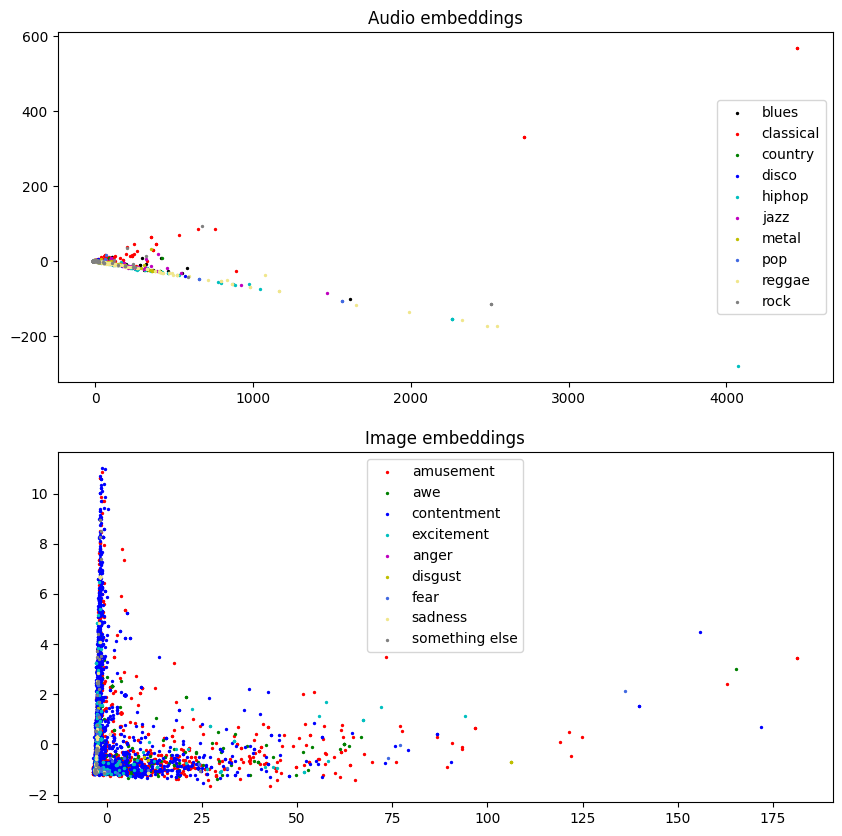

In [ ]:
fig,ax = plt.subplots(2, figsize= (10,10))

for genre in list(genre_cmap.keys()):

  genre_idx = df[df.genre == genre].index.values

  ax[0].scatter(wav_embs_pca[genre_idx,0], wav_embs_pca[genre_idx,1], s=2, c=genre_cmap[genre], label=genre)
  ax[0].set_title("Audio embeddings")

ax[0].legend()

for emo in list(emo_cmap.keys()):

  emo_idx = df[df.emo == emo].index.values

  ax[1].scatter(img_embs_pca[emo_idx,0], img_embs_pca[emo_idx,1], s=2, c=emo_cmap[emo], label=emo)
  ax[1].set_title("Image embeddings")

ax[1].legend()
# plt.show()

In [ ]:
emo_count = {"amusement": 0,
            "awe": 0,
            "contentment": 0,
            "excitement": 0,
            "anger": 0,
            "disgust": 0,
            "fear": 0,
            "sadness": 0,
            "something else": 0}

for emo in emos_txt:
  emo_count[emo] += 1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
IMEMNET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet"
emo_df = pd.read_csv(f'{IMEMNET_PATH}/genre+emo.csv')

In [ ]:
emos_txt = emo_df.emo.values.tolist()

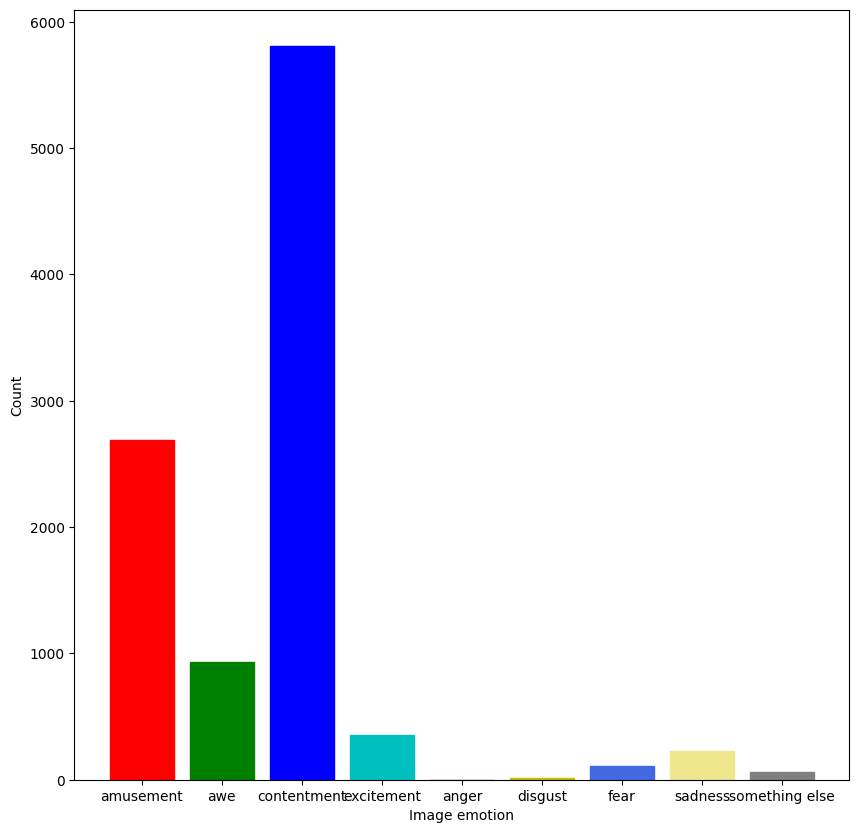

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.set_xlabel("Image emotion")
ax.set_ylabel("Count")
barlist = ax.bar(emo_count.keys(),emo_count.values())
for i,emo in enumerate(emo_count.keys()):
  barlist[i].set_color(emo_cmap[emo])